# Exploring Broadway Gross Dataset

This project aims to eventually predict the weekly gross revenue for a Broadway Show by building regression models using historical box office data and show features. Before we begin building the models, this project will first conduct an exploration of the dataset.

**EDA OBJECTIVES**

- Explore dataset through data visualizations
- Figure out which features would make sense for the model

**Questions for Data Exploration**

- Which features are most correlated with gross revenue?
- How does gross revenue vary by genre?
- Does seasonality impact gross revenue?
- How does average ticket price relate to gross revenue?
- Do theaters with more seats make more money?
- What are the highest and lowest grossing shows?
- Is Seats sold a good predictor of gross revenue?
- Is there a correlation between the number of awards a show has and its gross?


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import os

In [20]:
#Load scraped data
gross_df = pd.read_csv('broadway_gross_data.csv')
gross_df['Week'] = pd.to_datetime(gross_df['Week'])

In [21]:
gross_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1661 entries, 0 to 1660
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Show              1661 non-null   object        
 1   Week              1661 non-null   datetime64[ns]
 2   Theater           1661 non-null   object        
 3   This Week Gross   1661 non-null   object        
 4   Potential Gross   0 non-null      float64       
 5   Diff $            1661 non-null   object        
 6   Avg Ticket        1661 non-null   object        
 7   Top Ticket        1661 non-null   object        
 8   Seats Sold        1661 non-null   object        
 9   Seats in Theatre  1661 non-null   object        
 10  Performances      1661 non-null   int64         
 11  Previews          1661 non-null   int64         
 12  % Cap             1661 non-null   object        
 13  Diff % cap        1661 non-null   object        
 14  Genre             1661 n

In [22]:
gross_df.columns

Index(['Show', 'Week', 'Theater', 'This Week Gross', 'Potential Gross',
       'Diff $', 'Avg Ticket', 'Top Ticket', 'Seats Sold', 'Seats in Theatre',
       'Performances', 'Previews', '% Cap', 'Diff % cap', 'Genre',
       'Number of Awards', 'Awards', 'Season', 'Month'],
      dtype='object')

In [23]:
#Data Editing -- converting numeric columns into int or float
numeric_cols = ['This Week Gross', 'Avg Ticket', 'Top Ticket', 'Seats Sold', 'Seats in Theatre', 'Performances', 'Previews']
for col in numeric_cols:
  gross_df[col] = gross_df[col].astype(str).str.replace('$', '')
  gross_df[col] = gross_df[col].str.replace(',', '')

  gross_df[col] = pd.to_numeric(gross_df[col], errors = 'coerce') #force in case of error

In [24]:
gross_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1661 entries, 0 to 1660
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Show              1661 non-null   object        
 1   Week              1661 non-null   datetime64[ns]
 2   Theater           1661 non-null   object        
 3   This Week Gross   1661 non-null   float64       
 4   Potential Gross   0 non-null      float64       
 5   Diff $            1661 non-null   object        
 6   Avg Ticket        1661 non-null   float64       
 7   Top Ticket        1661 non-null   float64       
 8   Seats Sold        1661 non-null   int64         
 9   Seats in Theatre  1661 non-null   int64         
 10  Performances      1661 non-null   int64         
 11  Previews          1661 non-null   int64         
 12  % Cap             1661 non-null   object        
 13  Diff % cap        1661 non-null   object        
 14  Genre             1661 n

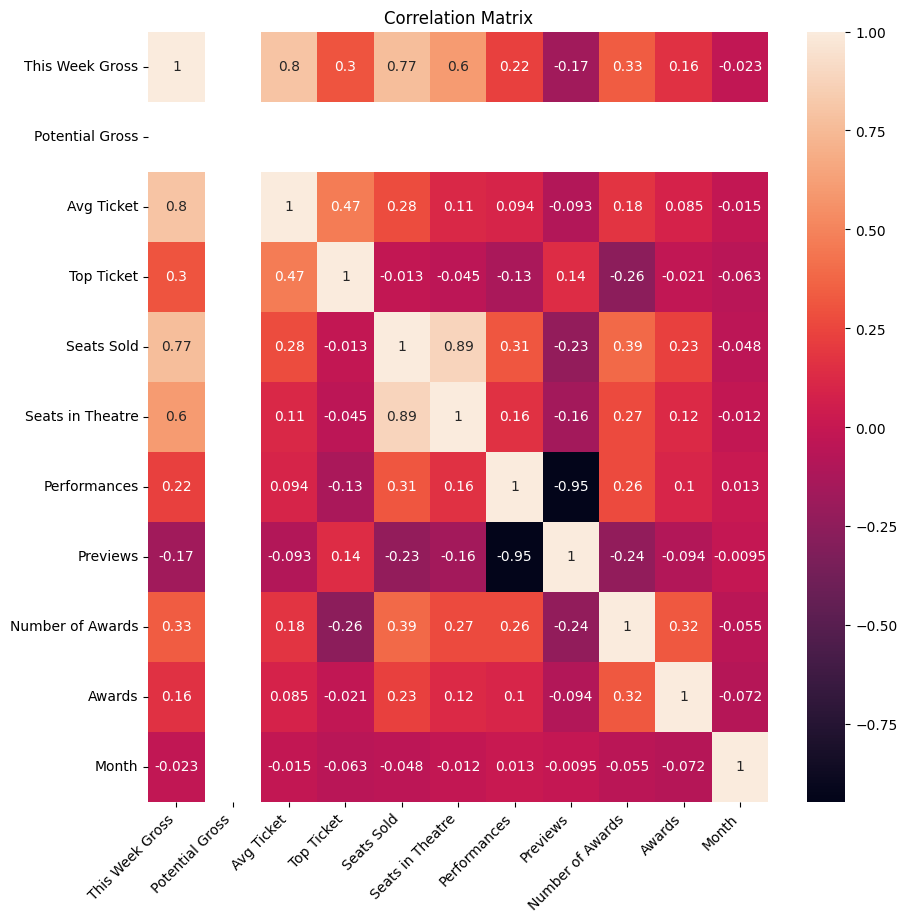

In [25]:
#Which features are most correlated with gross revenue?
plt.figure(figsize = (10, 10))
sns.heatmap(gross_df.select_dtypes(include = np.number).corr(), annot = True)
#make x labels rotated 45 degrees
plt.xticks(rotation=45, ha="right")
plt.title('Correlation Matrix');


Most to least:
Avg Ticket Price, Seats Sold, Seats in Theatre, Number of Awards, Top Ticket, Performances, Awards, Previews, Month(irrelevant)

Average Ticket Price seems to have the highest correlation with Gross Revenue with a correlation of .8, followed by Seats Sold with a correlation of .77. Both these features feel intuitive, but that’s because average ticket price times the number of seats sold would easily show the gross revenue. Therefore, for my model it’s important to keep in mind that I should just use one of these features. Other important features are: Seats in Theatre (.6), Number of Awards (.33), Top Ticket Price (.3)

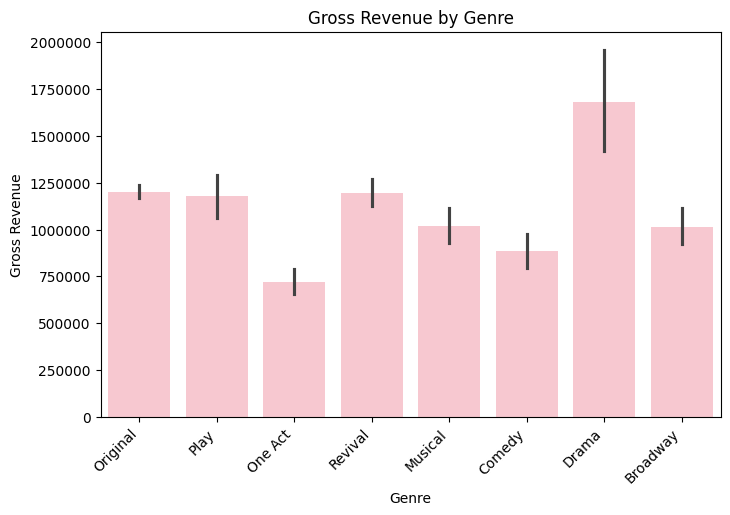

In [26]:
#How does gross revenue vary by genre?
plt.figure(figsize = (8, 5))
plt.xticks(rotation=45, ha="right")
plt.ticklabel_format(style='plain', axis='y') #disabling scientific notation for the y axis
sns.barplot(x = 'Genre', y = 'This Week Gross', data = gross_df, color='pink')
plt.title('Gross Revenue by Genre');
plt.ylabel('Gross Revenue');

Dramas and Revivals have the highest gross revenue, and one act and comedy have the least. The gap is significant with a difference of around $1,000,000 (Drama-One Act). Genre would be worth using in the model.

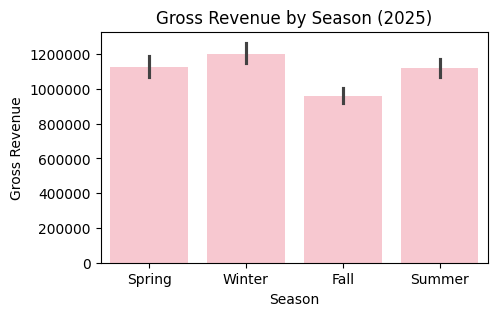

In [27]:
#Does seasonality impact gross revenue?
plt.figure(figsize = (5, 3)) #formatted to fit well in the write up
plt.ticklabel_format(style='plain', axis='y')
sns.barplot(x = 'Season', y = 'This Week Gross', data = gross_df, color='pink')
plt.title('Gross Revenue by Season (2025)')
plt.ylabel('Gross Revenue');

Yes. There is higher gross revenue during Winter and Summer, which are peak tourist seasons. Season would be worth using in the model.

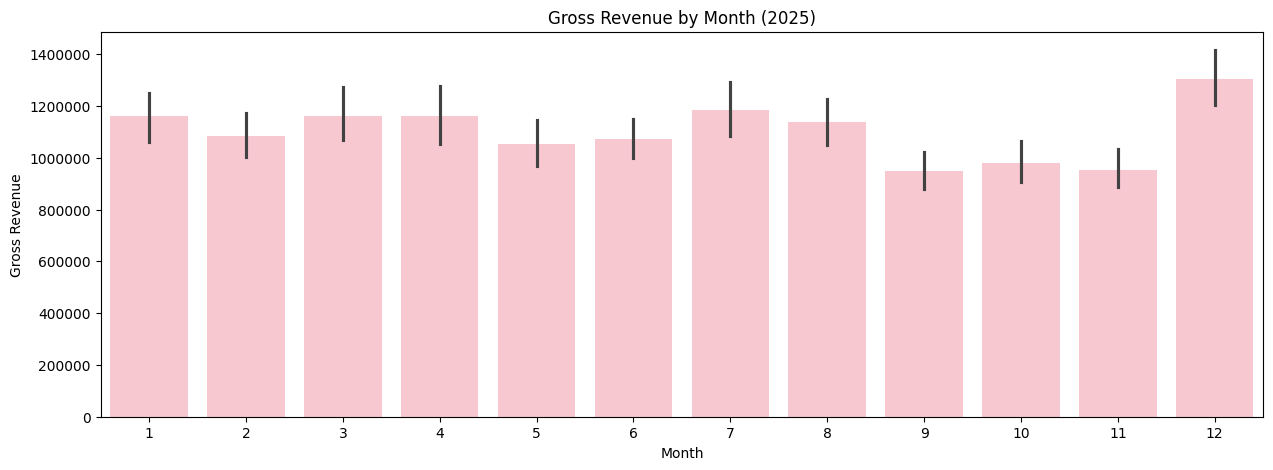

In [28]:
#Follow up: Does month affect gross revenue?
plt.figure(figsize = (15, 5))
plt.ticklabel_format(style='plain', axis='y')
sns.barplot(x = 'Month', y = 'This Week Gross', data = gross_df, color='pink')
plt.title('Gross Revenue by Month (2025)')
plt.ylabel('Gross Revenue');

Highest Gross: December (Peak Winter Tourist Season) USD 1.3 million

Second Highest Gross: July (Peak Summer Tourist Season) USD 1.19 million

Lowest Gross: September (Post Summer) USD 950k

Yes, month does seem to affect gross revenue. The gap is as much as USD 350k--month is worth using in the model

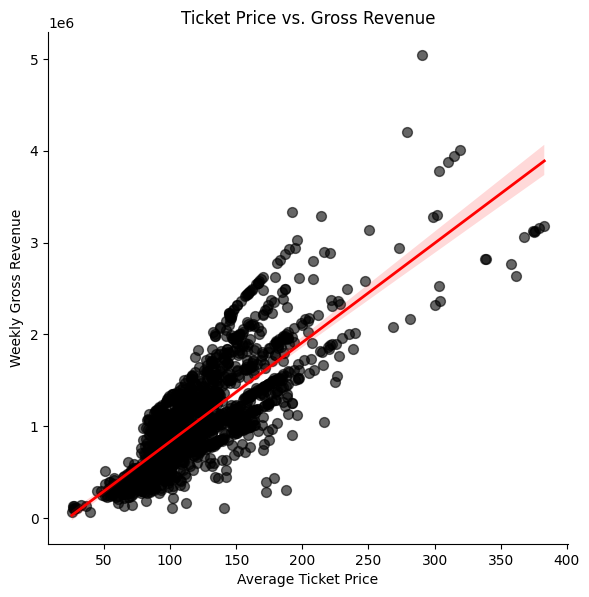

In [29]:
#How does average ticket price relate to gross revenue?
s = sns.lmplot(x = 'Avg Ticket', y = 'This Week Gross', data = gross_df, height = 6, aspect = 1, scatter_kws={"s":50, "alpha": 0.6, 'color': 'black'}, line_kws={"lw": 2, "color": "red"});
s.set(xlabel='Average Ticket Price', ylabel='Weekly Gross Revenue', title = "Ticket Price vs. Gross Revenue");

There appears to be a strong positive correlation between ticket price and gross revenue. However, once ticket price becomes higher than USD 200, there is no longer a correlation, implying that audience's demand generally stops at USD 200. That being said, below USD 200, Avg Ticket is a strong predictor of Weekly Gross Revenue. This should be in the model.

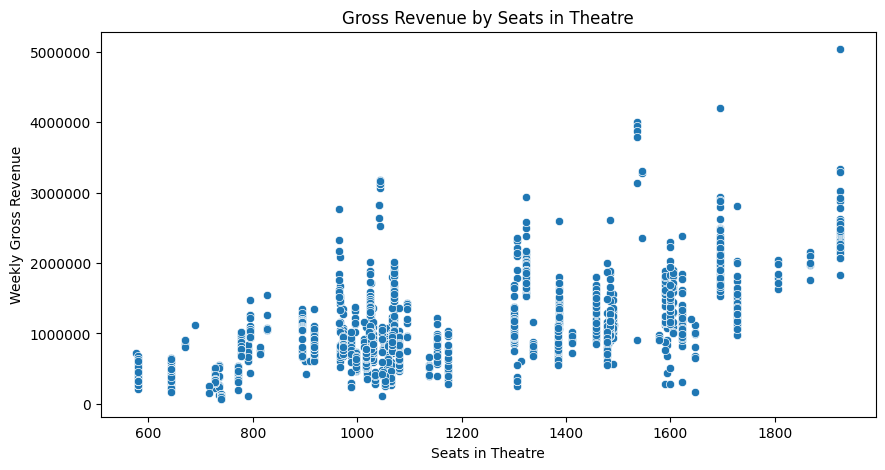

In [30]:
#Do theaters with more seats make more money?
plt.figure(figsize = (10, 5))
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Weekly Gross Revenue')
plt.title('Gross Revenue by Seats in Theatre')
sns.scatterplot(x = 'Seats in Theatre', y = 'This Week Gross', data = gross_df);

Yes, there is a slight positive correlation between seats in Theatre and Weekly Gross Revenue. Nothing too dramatic, but consistent. It’s worth trying to use this feature but it should also be the first one eliminated when trying to make the model better.


In [31]:
gross_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1661 entries, 0 to 1660
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Show              1661 non-null   object        
 1   Week              1661 non-null   datetime64[ns]
 2   Theater           1661 non-null   object        
 3   This Week Gross   1661 non-null   float64       
 4   Potential Gross   0 non-null      float64       
 5   Diff $            1661 non-null   object        
 6   Avg Ticket        1661 non-null   float64       
 7   Top Ticket        1661 non-null   float64       
 8   Seats Sold        1661 non-null   int64         
 9   Seats in Theatre  1661 non-null   int64         
 10  Performances      1661 non-null   int64         
 11  Previews          1661 non-null   int64         
 12  % Cap             1661 non-null   object        
 13  Diff % cap        1661 non-null   object        
 14  Genre             1661 n

In [32]:
gross_df.head()

,Show,Week,Theater,This Week Gross,Potential Gross,Diff $,Avg Ticket,Top Ticket,Seats Sold,Seats in Theatre,Performances,Previews,% Cap,Diff % cap,Genre,Number of Awards,Awards,Season,Month
0,Wicked,2025-05-04,Gershwin Theatre,2232068.00,NaN,"-$345,699.00",144.86,352.0,15408,1926,8,0,100.00%,0.00%,Original,33,1,Spring,5
1,The Picture of Dorian Gray,2025-05-04,Music Box Theatre,1344831.26,NaN,"$25,612.38",168.06,497.0,8002,995,8,0,100.53%,-0.14%,Play,17,1,Spring,5
2,The Outsiders,2025-05-04,Bernard B. Jacobs Theatre,1124988.24,NaN,"-$204,211.86",138.00,497.0,8152,1024,8,0,99.51%,-2.30%,Original,31,1,Spring,5
3,The Lion King,2025-05-04,Minskoff Theatre,1999729.00,NaN,"-$320,876.00",153.10,222.0,13062,1696,8,0,96.27%,-2.15%,Original,32,1,Spring,5
4,The Last Five Years,2025-05-04,Hudson Theatre,613501.45,NaN,"-$146,227.05",94.46,425.0,6495,968,8,0,83.87%,-8.70%,One Act,3,1,Spring,5


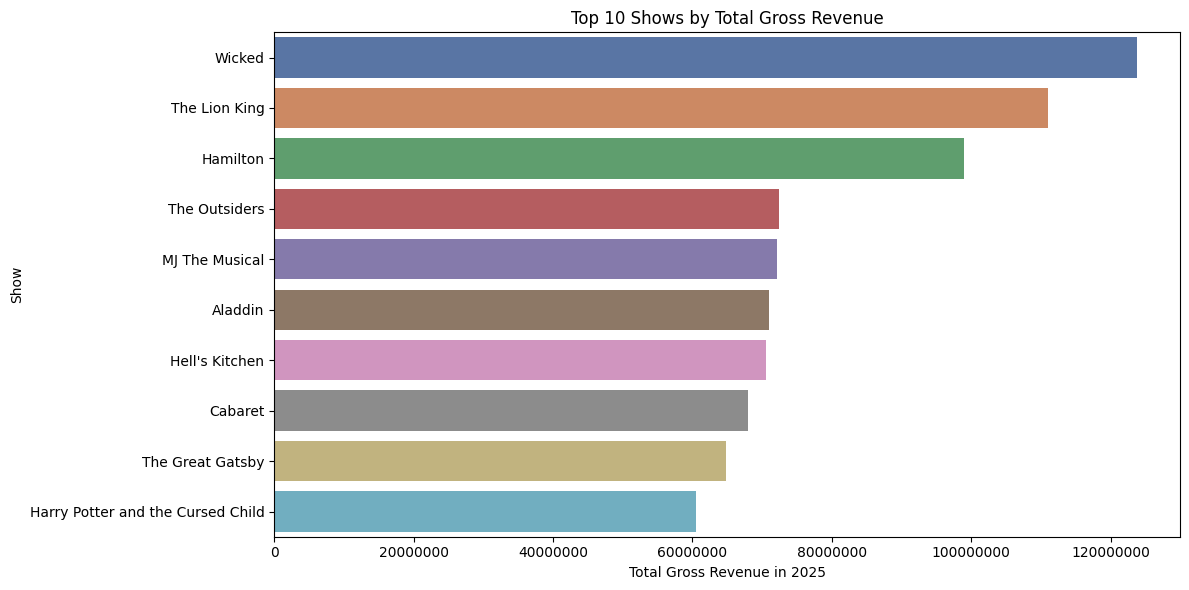

In [33]:
#What are the highest and lowest grossing shows?
#This would be irrelevant for the model because we are predicting weekly gross for individual shows
#This is nice to know, though.

#Create a separate df considering the current df has rows with the same shows and we want to group them together, add their gross revenue in 2025
gross_by_show = gross_df.groupby('Show')['This Week Gross'].sum()

#sort in descending order
gross_by_show = gross_by_show.sort_values(ascending=False)

#Converting to a dataframe in order to plot
gross_by_show_df = gross_by_show.reset_index()

plt.figure(figsize=(12,6))
plt.ticklabel_format(style='plain', axis='x')
sns.barplot(x='This Week Gross', y= 'Show' , data=gross_by_show_df.head(10), hue = 'Show' , legend= False, palette='deep')
plt.title("Top 10 Shows by Total Gross Revenue")
plt.xlabel("Total Gross Revenue in 2025")
plt.ylabel("Show")
plt.tight_layout();

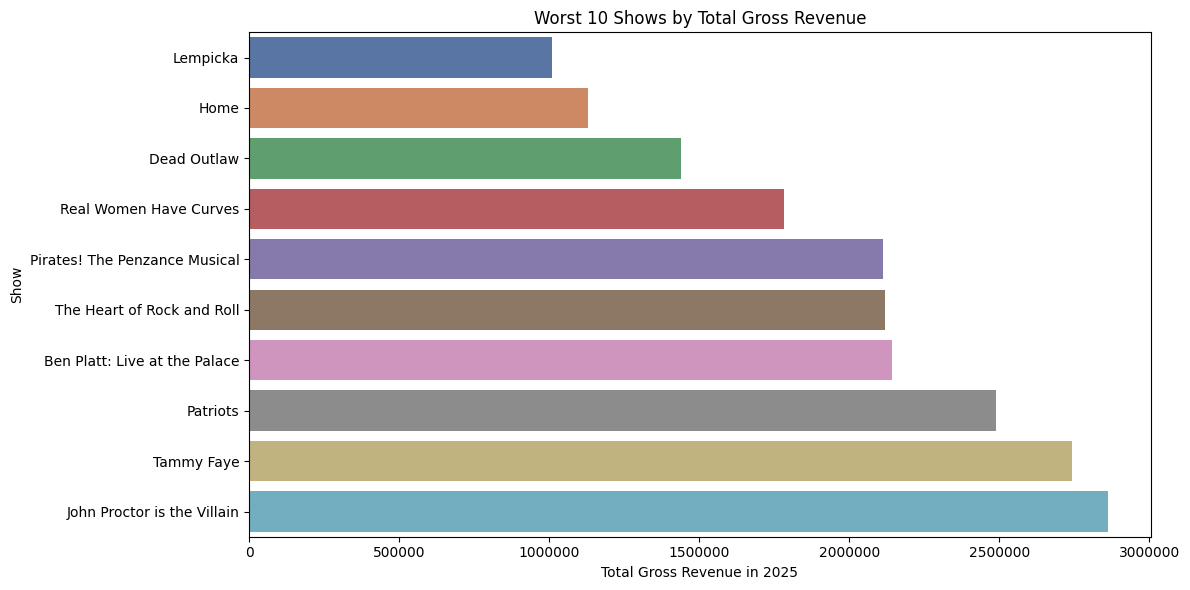

In [34]:
#sort in ascending order
gross_by_show = gross_by_show.sort_values(ascending=True)

#Converting to a dataframe in order to plot
gross_by_show_df = gross_by_show.reset_index()
plt.figure(figsize=(12,6))
plt.ticklabel_format(style='plain', axis='x')
sns.barplot(x='This Week Gross', y='Show', data=gross_by_show_df.head(10), hue = 'Show', legend= False, palette='deep')
plt.title("Worst 10 Shows by Total Gross Revenue")
plt.xlabel("Total Gross Revenue in 2025")
plt.ylabel("Show")
plt.tight_layout();

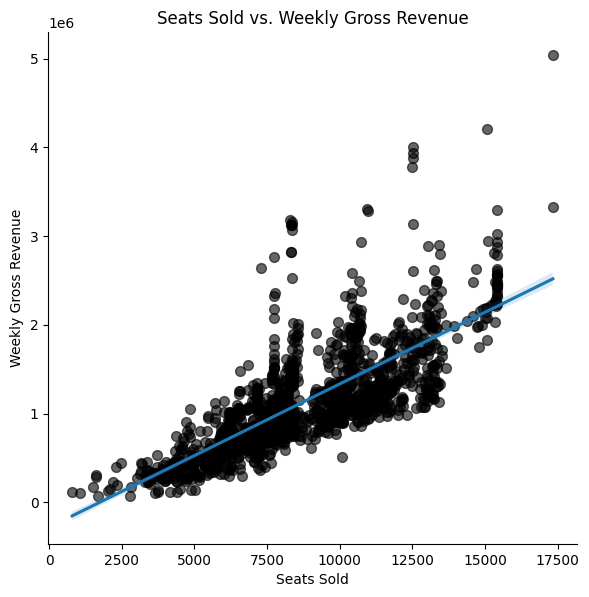

In [35]:
#Is Seats sold a good predictor of gross revenue?
s = sns.lmplot(x = 'Seats Sold', y = 'This Week Gross', data = gross_df, height = 6, aspect = 1, scatter_kws={"s":50, "alpha": 0.6, 'color': 'black'})
s.set(xlabel='Seats Sold', ylabel='Weekly Gross Revenue', title = 'Seats Sold vs. Weekly Gross Revenue');

Yes, there appears to be a strong positive correlation between number of seats sold with the weekly gross revenue. This is a solid predictor (and intuitive), but should not be used together with average ticket price.


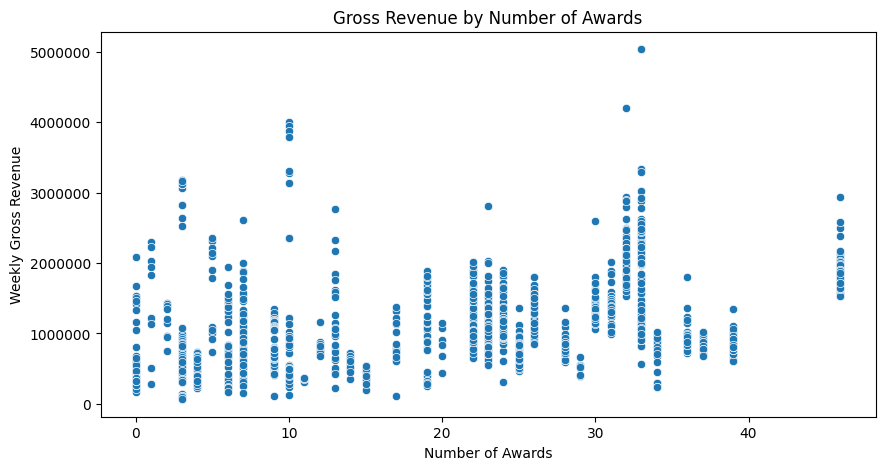

In [36]:
#Is there a correlation between the number of awards a show has and its gross?
plt.figure(figsize = (10, 5))
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Weekly Gross Revenue')
plt.title('Gross Revenue by Number of Awards')
sns.scatterplot(x = 'Number of Awards', y = 'This Week Gross', data = gross_df);

No, there is no significant correlation between the number of awards a show has and its gross. This feature shouldn’t be added to the model since it would be unhelpful.


###Conclusion

In conclusion, the features that I should start the model with are: Average ticket price OR seats sold (pick one), genre, seasonality, month, and seats in theater.
